# Feature Engineering

Featurization has finished. Featurized data was saved in `mrp7pred/feats/all_features_cc` (cancer cell paper data) and `mrp7pred/feats/all_features_man` (manually curated data). 

In this notebook we experimented on different feature selection strategies to determine a subset of features for further model training.

In [477]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

from pandas import DataFrame
import pandas as pd
import numpy as np
from sklearn.feature_selection import (
    VarianceThreshold,
    GenericUnivariateSelect,
    SelectorMixin,
    chi2,
    f_classif,
    mutual_info_classif,
    SelectKBest,
    RFECV,
    SelectFromModel,
    SequentialFeatureSelector,
)

from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.preprocessing import Normalizer, StandardScaler

from mrp7pred.feats.feature_selection import (
    _remove_low_variance_features,
    _remove_similar_features,
    _univariate,
    _from_model,
    _rfecv
)
from mrp7pred.preprocess import split_data
from mrp7pred.train import _train
from mrp7pred.utils import plot_roc_auc, plot_precision_recall, NoScaler
from mrp7pred.scoring import get_scoring

DATA_CC = "../mrp7pred/feats/all_features_cc/cc_full_features_828_20210115-135540.csv"
DATA_MAN = "../mrp7pred/feats/all_features_man/man_full_features_828_20210115-085233.csv"
FULL_DATA = "../data/all_compounds_828_features_renamed.csv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Cancer Cell paper and manually curated data

In [147]:
df_all = pd.read_csv(FULL_DATA, index_col=0)
df_cc = df_all[df_all["name"].str.contains("NSC")]
df_man = df_all[~df_all.name.isin(df_cc.name)]

In [148]:
df_cc.head()

,name,std_smiles,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,...,pychem_ATSe8,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8,label
116,NSC186,CC1=C2C(=CO[C@H](C)[C@@H]2C)C(O)=C(C(=O)O)C1=O,0.384615,18.0,236.138,2.0,5.0,2.0,1.0,1.0,...,1.296,2.817,3.190,3.326,3.126,2.626,1.862,1.340,0.647,1
117,NSC186,CC1=C2C(=CO[C@H](C)[C@@H]2C)C(O)=C(C(=O)O)C1=O,0.384615,18.0,236.138,2.0,5.0,2.0,1.0,1.0,...,1.296,2.817,3.190,3.326,3.126,2.626,1.862,1.340,0.647,1
118,NSC740,CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@H](CCC...,0.250000,33.0,432.271,7.0,13.0,3.0,0.0,0.0,...,3.622,3.320,3.592,3.630,3.538,3.458,3.401,3.325,3.197,0
119,NSC742,[N-]=[N+]=CC(=O)OC[C@H](N)C(=O)O,0.400000,12.0,166.072,3.0,7.0,0.0,0.0,0.0,...,1.406,2.069,2.102,1.926,1.738,1.709,1.377,0.949,0.450,0
120,NSC750,CS(=O)(=O)OCCCCOS(C)(=O)=O,1.000000,14.0,232.194,0.0,6.0,0.0,0.0,0.0,...,2.182,2.541,2.413,2.305,2.200,2.119,1.843,1.696,1.987,0


In [149]:
df_man.head()

,name,std_smiles,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,...,pychem_ATSe8,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8,label
0,paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,1.0,...,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748,1
1,vincristine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,5.0,...,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799,1
2,LTC4,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,0.0,...,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888,1
3,E217bG,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,1.0,...,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258,1
4,gemcitabine,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,1.0,...,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860,1


In [150]:
df_cc.shape, df_man.shape

((1115, 831), (116, 831))

#### Link labels back to the data

In [127]:
df_raw = pd.read_csv(RAW_DATA, index_col=0)
df_raw.duplicated(subset=["name"]).sum()

0

In [128]:
df_raw[df_raw.duplicated(subset=["std_smiles"], keep=False)]

,name,label,std_smiles
66,mitoxantrone,0,O=C1c2c(O)ccc(O)c2C(=O)c2c(NCCNCCO)ccc(NCCNCCO...
16,NSC5889,0,CC(=O)c1c(O)c(C)c(O)c2c1OC1=CC(=O)[C@@H](C(C)=...
17,NSC5890,0,CC(=O)c1c(O)c(C)c(O)c2c1OC1=CC(=O)[C@@H](C(C)=...
97,NSC71261,0,Nc1nc(S)c2ncn([C@@H]3C[C@H](O)[C@H](CO)O3)c2n1
99,NSC71851,0,Nc1nc(S)c2ncn([C@@H]3C[C@H](O)[C@H](CO)O3)c2n1
138,NSC100046,0,C=C(C)C(=O)O[C@H]1CC2=C[C@H](C[C@]3(C)O[C@H]3[...
155,NSC112167,0,CC(C)(O)/C=C\C(=O)[C@@](C)(O)[C@@H]1[C@@H](O)C...
179,NSC129943,0,C[C@H](CN1CC(=O)NC(=O)C1)N1CC(=O)NC(=O)C1
259,NSC169780,0,C[C@H](CN1CC(=O)NC(=O)C1)N1CC(=O)NC(=O)C1
303,NSC224369,0,O=c1c(Cl)c(Cl)cnn1-c1ccccc1


In [129]:
# df_raw.drop_duplicates(subset=["std_smiles"], inplace=True)

In [130]:
# create a dictionary of {"name" : {"label" : 0}}
name_label_d = df_raw[["name", "label"]].set_index('name').T.to_dict()

In [131]:
df_all["label"] = df_all["name"].apply(lambda x: name_label_d.get(x)["label"])

In [132]:
len_1 = len(df_all[df_all["label"]==1])
len_0 = len(df_all[df_all["label"]==0])
len_1, len_0, f"pos/neg = {round(len_1/len_0, 3)}"

(144, 1087, 'pos/neg = 0.132')

In [152]:
df_all = df_all.rename(columns={"std_smiles" : "smiles"})

In [153]:
df_all.to_csv("../data/all_compounds_828_features_renamed.csv")

## Split train test

In [412]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(df_all, ratio=0.7, featurized=True)
len(X_train), len(y_train), len(X_test), len(y_test)

Spliting training and test data ... Done!
train_1: 101; train_0: 760; test_1: 43; test_0: 327


(861, 861, 370, 370)

In [413]:
type(X_train),  type(X_test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

## Scaling data

Use `sklearn.preprocessing.StandardScaler`

In [414]:
transformer_tr = StandardScaler().fit(X_train)
transformer_te = StandardScaler().fit(X_test)

X_train = transformer_tr.transform(X_train)
X_test = transformer_te.transform(X_test)

X_train, X_test

(array([[-0.6852489 , -0.78410013, -0.92477036, ..., -0.63170896,
         -0.74984489, -0.98899225],
        [-0.82374606,  0.90661578,  0.80030962, ...,  0.76992003,
          0.58619116,  0.66279517],
        [ 0.17789284, -0.4165532 , -0.51628998, ..., -0.38397406,
         -0.15647645,  0.00575827],
        ...,
        [-0.89372358, -0.63708136, -0.72067479, ..., -0.58106093,
         -0.36894063, -0.18650444],
        [-0.27490283, -0.49006258, -0.4820056 , ..., -0.39388346,
         -0.19380123,  0.1010537 ],
        [ 1.91703984, -0.34304381, -0.49345074, ..., -0.38177197,
         -0.17274622,  0.04421081]]),
 array([[-1.23337882, -0.45835921, -0.47027403, ..., -0.16637159,
         -0.10426344,  0.09014243],
        [-1.17027217, -0.87918529, -0.88856852, ..., -0.53098069,
         -0.41488793, -0.44024645],
        [-0.00853622, -0.03753314, -0.11674148, ...,  0.43072703,
          0.35775786,  0.18401657],
        ...,
        [ 1.19622699,  0.45343062,  0.38727525, ...,  

In [415]:
type(X_train),  type(X_test)

(numpy.ndarray, numpy.ndarray)

## Remove low variance features

Threshold = 0.0

In [419]:
X_train.shape

(861, 696)

In [420]:
support_lowvar, X_train = _remove_low_variance_features(X_train)
X_train.shape

(861, 696)

In [422]:
X_test = X_test[:, support_lowvar]
X_test.shape

(370, 696)

In [423]:
type(X_train), type(X_test)

(numpy.ndarray, numpy.ndarray)

## Remove similar features

Threshold = 0.9 (PCC)

In [424]:
support_similar, X_train = _remove_similar_features(X_train)

Calculating correlation matrix ... Done!
Creating correlation graph ... Done!


In [425]:
X_train.shape, type(X_train)

((861, 312), pandas.core.frame.DataFrame)

In [427]:
X_test = X_test[:, support_similar]
X_test.shape

(370, 312)

In [428]:
X_test = pd.DataFrame(X_test, columns=X_train.columns)

In [429]:
type(X_train), type(X_test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

## Univariate

#### 1. chi2

X must be non-negative. We have negatives in the data which is necessary, thus skip for now.

In [430]:
# selected_feature_idx = _univariate(X_train, y_train, n_features=100, score_function=chi2)
# selected_feature_idx

#### 2. f_classif

In [431]:
selected_feature_f_idx = _univariate(X_train, y_train, n_features=200, score_function=f_classif)
len(selected_feature_f_idx), selected_feature_f_idx

(200,
 array([  1,   6,   7,   9,  10,  11,  13,  14,  15,  17,  18,  20,  21,
         22,  23,  25,  27,  28,  29,  30,  34,  36,  38,  40,  41,  46,
         47,  49,  51,  58,  60,  61,  64,  65,  68,  69,  71,  73,  74,
         75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  89,  91,
         92,  93,  94,  95,  96,  99, 100, 101, 102, 103, 106, 107, 109,
        112, 113, 114, 115, 116, 117, 119, 121, 122, 123, 125, 126, 127,
        131, 132, 133, 135, 136, 139, 140, 143, 144, 145, 146, 147, 148,
        149, 150, 151, 152, 154, 155, 160, 161, 166, 167, 168, 170, 171,
        174, 176, 177, 178, 179, 181, 183, 184, 186, 187, 188, 191, 192,
        193, 194, 200, 202, 205, 206, 207, 208, 209, 210, 211, 212, 213,
        214, 216, 218, 220, 221, 222, 223, 224, 226, 227, 230, 231, 232,
        236, 238, 239, 240, 241, 243, 246, 247, 248, 249, 250, 251, 253,
        254, 257, 258, 259, 260, 261, 262, 263, 266, 267, 269, 271, 273,
        275, 277, 278, 279, 280, 281, 282, 28

#### 3. mutual_info_classif

In [432]:
selected_feature_mut_idx = _univariate(X_train, y_train, n_features=200, score_function=mutual_info_classif)
len(selected_feature_mut_idx), selected_feature_mut_idx

(200,
 array([  0,   1,   2,   4,   5,   7,   8,   9,  12,  13,  14,  15,  16,
         17,  21,  22,  25,  27,  32,  33,  35,  36,  37,  38,  45,  48,
         49,  50,  52,  53,  55,  56,  58,  60,  64,  69,  71,  72,  73,
         74,  76,  78,  79,  80,  81,  82,  83,  84,  86,  88,  90,  91,
         92,  95,  98,  99, 100, 101, 102, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 115, 116, 118, 121, 124, 125, 126, 128, 130,
        131, 132, 133, 135, 136, 137, 138, 142, 143, 144, 145, 146, 148,
        150, 151, 153, 157, 158, 159, 160, 165, 167, 168, 170, 171, 175,
        177, 178, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
        193, 194, 195, 196, 197, 198, 200, 202, 205, 207, 209, 210, 213,
        214, 216, 217, 219, 222, 225, 226, 228, 231, 233, 236, 237, 239,
        240, 241, 243, 245, 246, 247, 248, 249, 250, 251, 254, 256, 257,
        258, 260, 261, 264, 265, 266, 268, 269, 271, 272, 275, 276, 278,
        279, 280, 281, 282, 283, 286, 287, 28

Find intersections

In [433]:
intersect_univar = set(selected_feature_f_idx.tolist()) & set(selected_feature_mut_idx.tolist())
print(len(intersect_univar), intersect_univar)

133 {1, 7, 9, 13, 14, 15, 17, 21, 22, 25, 27, 36, 38, 49, 58, 60, 64, 69, 71, 73, 74, 76, 78, 80, 81, 82, 83, 84, 86, 91, 92, 95, 99, 100, 101, 102, 106, 107, 109, 112, 113, 115, 116, 121, 125, 126, 131, 132, 133, 135, 136, 143, 144, 145, 146, 148, 150, 151, 160, 167, 168, 170, 171, 177, 178, 183, 184, 186, 187, 188, 191, 192, 193, 194, 200, 202, 205, 207, 209, 210, 213, 214, 216, 222, 226, 231, 236, 239, 240, 241, 243, 246, 247, 248, 249, 250, 251, 254, 257, 258, 260, 261, 266, 269, 271, 275, 278, 279, 280, 281, 282, 283, 286, 287, 288, 289, 291, 292, 293, 294, 295, 296, 297, 298, 302, 303, 304, 305, 306, 307, 308, 310, 311}


## SelectFromModel

#### 1. l1-based_from_model

In [434]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
selected_feature_fm_idx = _from_model(X_train, y_train, estimator=lsvc, max_features=200)

In [435]:
print(len(selected_feature_fm_idx), selected_feature_fm_idx)

8 [ 14  46  60  64  82 126 140 178]


#### 2. tree-based

In [436]:
clf = ExtraTreesClassifier(n_estimators=50).fit(X_train, y_train)
selected_feature_tree_idx = _from_model(X_train, y_train, estimator=clf, max_features=200)

In [437]:
print(len(selected_feature_tree_idx), selected_feature_tree_idx)

173 [  9  14  18  22  26  27  29  30  34  48  51  64  71  73  74  75  76  77
  78  80  81  82  85  86  88  89  90  92  93  94  99 100 102 105 106 107
 108 109 110 111 113 114 115 116 117 119 120 121 122 123 125 126 127 129
 130 131 132 133 134 135 138 140 143 146 147 148 151 152 154 167 168 170
 178 182 185 187 188 191 192 193 194 195 196 197 198 199 200 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 239 240 241
 243 246 248 250 252 253 255 256 257 259 260 262 265 266 268 269 272 273
 274 277 279 280 282 283 284 285 288 289 290 291 292 294 296 297 298 299
 300 301 302 304 305 306 307 308 309 310 311]


## RFECV

In [438]:
selected_feature_rfecv_idx = _rfecv(X_train, y_train, estimator=lsvc, min_features_to_select=200)

Fitting estimator with 312 features.
Fitting estimator with 297 features.
Fitting estimator with 282 features.
Fitting estimator with 267 features.
Fitting estimator with 252 features.
Fitting estimator with 237 features.
Fitting estimator with 222 features.
Fitting estimator with 207 features.


In [439]:
print(len(selected_feature_rfecv_idx), selected_feature_rfecv_idx)

200 [  8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 140 145 146 178 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291
 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309
 310 311]


## Let's vote

In [440]:
set_f = set(selected_feature_f_idx.tolist())
set_mut = set(selected_feature_mut_idx.tolist())
set_tree = set(selected_feature_tree_idx.tolist())
set_rfecv = set(selected_feature_rfecv_idx.tolist())

selected_feats = set.intersection(set_f, set_mut, set_tree, set_rfecv)
print(len(selected_feats), selected_feats)

60 {257, 131, 132, 133, 260, 135, 9, 266, 269, 14, 146, 22, 279, 280, 282, 27, 283, 288, 289, 291, 292, 294, 296, 297, 298, 302, 304, 305, 178, 306, 307, 308, 310, 311, 64, 71, 73, 74, 76, 78, 80, 81, 82, 86, 92, 99, 100, 102, 106, 107, 109, 113, 115, 116, 246, 248, 121, 250, 125, 126}


## Train new models using selected features

#### Notice: the `_remove_similar_function()` renamed the columns of X_train to indices. In the following feature selection steps, the returned indices are NOT column names but indices of `X_train.columns`. This means numbers in `selected_feats` are not equal to "selected" column numbers.

In [441]:
feats_id = list(selected_feats)
print(feats_id)

[257, 131, 132, 133, 260, 135, 9, 266, 269, 14, 146, 22, 279, 280, 282, 27, 283, 288, 289, 291, 292, 294, 296, 297, 298, 302, 304, 305, 178, 306, 307, 308, 310, 311, 64, 71, 73, 74, 76, 78, 80, 81, 82, 86, 92, 99, 100, 102, 106, 107, 109, 113, 115, 116, 246, 248, 121, 250, 125, 126]


In [442]:
X_train = X_train.iloc[:, feats_id]

In [443]:
X_train.shape, type(X_train)

((861, 60), pandas.core.frame.DataFrame)

In [445]:
X_test = X_test.iloc[:, feats_id]

In [446]:
X_test.shape, type(X_test)

((370, 60), pandas.core.frame.DataFrame)

In [458]:
grid = [
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [100, 1000],
        "clf__class_weight": [{0: 1, 1: 10}, {0: 1, 1: 100}, {0: 1, 1: 1000}, {0: 1, 1: 10000}],
        "sclr": [NoScaler()],
    },
    {
        "clf": [XGBClassifier()],
        "clf__n_estimators": [100, 1000],
        "clf__scale_pos_weight": [10, 100, 1000, 10000],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["rbf", "linear"],
        "clf__class_weight": [{0: 1, 1: 10}, {0: 1, 1: 100}, {0: 1, 1: 1000}, {0: 1, 1: 10000}],
        "sclr": [NoScaler()],
    },
    {
        "clf": [MLPClassifier()],
        "clf__solver": ["lbfgs"],
        "clf__max_iter": [1000, 2000],
        "clf__alpha": [0.1, 1],
        "clf__hidden_layer_sizes": [10, 15],
        "sclr__scaler": [NoScaler()],
    },
]

In [459]:
pipe = _train(X_train, y_train, grid=grid, verbose=10, n_jobs=-1, scoring="balanced_accuracy")

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Cross-validation scores                                                                               0   \
mean_fit_time                                                           0.340947   
std_fit_time                                                            0.035072   
mean_score_time                                                         0.023360   
std_score_time                                                          0.002384   
param_clf                                               RandomForestClassifier()   
param_clf__class_weight                                            {0: 1, 1: 10}   
param_clf__n_estimators                                                      100   
param_sclr                                                            NoScaler()   
param_clf__scale_pos_weight                                                  NaN   
param_clf__kernel                                                        

Pipeline(steps=[('sclr', NoScaler()),
                ('clf', SVC(class_weight={0: 1, 1: 10}, probability=True))])
stats
tp: 19.0
fp: 88.0
tn: 239.0
fn: 24.0
score
roc_auc: 0.5849868430410355
accuracy: 0.6972972972972973
precision: 0.17757009345794392
recall: 0.4418604651162791
specificity: 0.7308868501529052
mcc: 0.12210955472964406


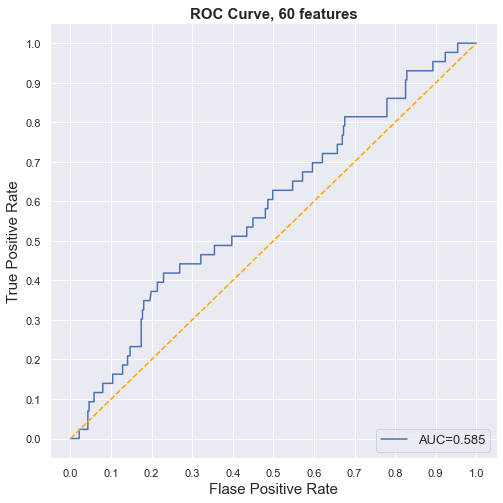

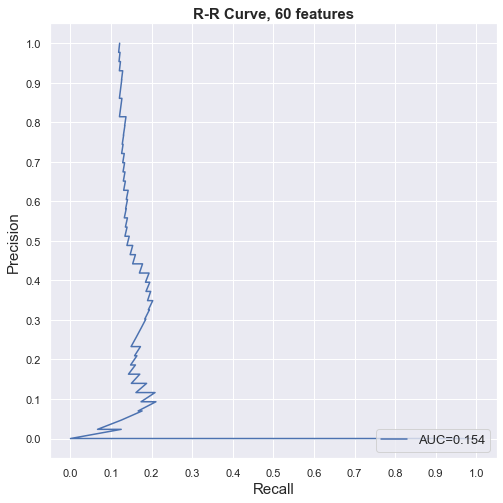

In [460]:
print(pipe)
test_score = pipe.score(X_test, y_test)
y_pred = pipe.predict(X_test)
y_score = [score[1] for score in pipe.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {len(feats_id)} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {len(feats_id)} features")

# Use manual data only

In [461]:
df_man

,name,std_smiles,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,...,pychem_ATSe8,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8,label
0,paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,1.0,...,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748,1
1,vincristine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,5.0,...,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799,1
2,LTC4,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,0.0,...,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888,1
3,E217bG,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,1.0,...,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258,1
4,gemcitabine,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,1.0,...,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,CCTA-45,O=C(Nc1cccc(-c2cc(F)cc(F)c2)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.683,2.987,3.254,3.163,3.045,3.063,2.856,2.604,2.351,0
112,CCTA-46,O=C(Nc1cccc(-c2cc(F)c(F)c(F)c2)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,2.877,3.003,3.278,3.198,3.060,3.078,2.892,2.650,2.399,0
113,CCTA-47,O=C(Nc1cccc(-c2cc(F)ccc2F)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.807,2.987,3.254,3.177,3.055,3.067,2.849,2.590,2.365,0
114,CCTA-48,O=C(Nc1cccc(-c2ccc(F)c(F)c2F)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,2.981,3.003,3.278,3.211,3.075,3.078,2.885,2.636,2.412,0


In [462]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(df_man.rename(columns={"std_smiles":"smiles"}), ratio=0.7, featurized=True)
len(X_train), len(y_train), len(X_test), len(y_test)

Spliting training and test data ... Done!
train_1: 40; train_0: 41; test_1: 13; test_0: 22


(81, 81, 35, 35)

In [463]:
transformer_tr = StandardScaler().fit(X_train)
transformer_te = StandardScaler().fit(X_test)

X_train = transformer_tr.transform(X_train)
X_test = transformer_te.transform(X_test)

X_train, X_test

(array([[ 7.80319771e-01,  2.27630045e+00,  2.29191362e+00, ...,
          1.72688967e+00,  1.73351792e+00,  1.66046810e+00],
        [ 1.70972841e+00,  4.45783817e+00,  4.50306405e+00, ...,
          2.08600397e+00,  2.15920060e+00,  2.15475675e+00],
        [-7.03318213e-01, -6.32416514e-01, -5.11671876e-01, ...,
         -3.94928044e-01, -3.66963547e-01, -2.41554587e-01],
        ...,
        [-7.03318213e-01, -3.09225740e-01,  4.08864371e-01, ...,
         -4.16299064e-03,  9.33547318e-02,  2.24065313e-01],
        [ 7.69976326e-01, -1.03640498e+00, -1.15585459e+00, ...,
         -1.44548954e+00, -1.74344927e+00, -2.06350252e+00],
        [ 1.38153255e+00,  2.56358114e-01,  1.73277737e-01, ...,
          2.06436243e-01,  2.43069900e-01,  2.35928240e-01]]),
 array([[-0.2699413 ,  0.70420623,  0.60871999, ...,  0.97651208,
          0.98227026,  1.044827  ],
        [ 0.27094697,  0.27502582,  0.17920074, ...,  0.32190931,
          0.39812459,  0.47612168],
        [-0.69223909, -0.

In [464]:
support_similar, X_train = _remove_similar_features(X_train)
X_train.shape

Calculating correlation matrix ... Done!
Creating correlation graph ... Done!


(81, 420)

In [465]:
X_test = X_test[:, support_similar]
X_test.shape

(35, 420)

In [466]:
selected_feature_f_idx = _univariate(X_train, y_train, n_features=200, score_function=f_classif)
len(selected_feature_f_idx), selected_feature_f_idx

(200,
 array([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,  13,  15,  16,
         17,  21,  22,  25,  26,  30,  32,  36,  44,  45,  48,  54,  55,
         56,  57,  60,  62,  66,  68,  69,  72,  73,  75,  76,  77,  78,
         80,  81,  82,  83,  84,  85,  86,  88,  89,  91,  92,  94,  95,
         96,  97,  98,  99, 100, 101, 103, 104, 105, 106, 109, 110, 111,
        112, 113, 114, 115, 116, 119, 121, 128, 129, 132, 133, 138, 140,
        181, 182, 183, 184, 186, 187, 189, 192, 193, 195, 196, 197, 198,
        199, 211, 212, 213, 244, 246, 248, 250, 252, 253, 258, 261, 263,
        264, 265, 276, 292, 297, 302, 303, 304, 305, 306, 308, 309, 310,
        312, 313, 314, 315, 316, 317, 318, 320, 321, 322, 323, 324, 325,
        326, 327, 328, 329, 330, 331, 332, 333, 335, 336, 337, 338, 340,
        342, 345, 347, 349, 351, 352, 353, 355, 357, 358, 359, 360, 361,
        362, 363, 364, 365, 366, 367, 369, 371, 372, 373, 374, 375, 376,
        381, 382, 383, 384, 386, 387, 389, 39

In [467]:
selected_feature_mut_idx = _univariate(X_train, y_train, n_features=200, score_function=mutual_info_classif)
len(selected_feature_mut_idx), selected_feature_mut_idx

(200,
 array([  0,   2,   3,   4,   7,  15,  21,  23,  25,  27,  30,  32,  33,
         35,  37,  39,  43,  45,  49,  54,  68,  69,  71,  72,  73,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  94,  96,  97,  98, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 115, 119, 120, 121, 124, 128, 129, 130,
        132, 133, 136, 138, 141, 143, 151, 153, 155, 157, 164, 175, 176,
        181, 182, 183, 184, 186, 187, 192, 194, 196, 198, 201, 203, 204,
        206, 207, 212, 219, 220, 224, 231, 238, 240, 242, 244, 247, 248,
        251, 254, 256, 260, 262, 264, 265, 272, 277, 280, 284, 288, 301,
        302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 314, 315, 316,
        319, 321, 323, 325, 327, 328, 329, 330, 331, 332, 333, 334, 335,
        336, 337, 340, 341, 342, 343, 344, 345, 353, 354, 355, 357, 358,
        360, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374,
        375, 376, 377, 379, 383, 384, 385, 38

In [468]:
clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
selected_feature_tree_idx = _from_model(X_train, y_train, estimator=clf, max_features=200)
print(len(selected_feature_tree_idx), selected_feature_tree_idx)

135 [  0   9  21  32  69  72  73  75  77  79  80  81  82  83  85  87  88  89
  90  91  93  94  97  98  99 100 103 104 105 106 107 110 111 112 113 114
 115 117 119 120 121 128 129 130 138 181 183 186 187 189 196 244 248 251
 253 261 263 302 303 304 305 307 308 309 310 311 312 316 317 318 319 322
 324 325 326 327 328 330 331 332 333 334 335 336 337 338 342 344 345 346
 347 348 350 351 352 353 355 357 358 359 360 361 363 364 365 367 368 369
 371 372 373 374 376 384 386 387 389 392 394 395 398 399 400 401 402 404
 405 406 407 412 413 414 416 418 419]


In [469]:
selected_feature_rfecv_idx = _rfecv(X_train, y_train, estimator=lsvc, min_features_to_select=200)
print(len(selected_feature_rfecv_idx), selected_feature_rfecv_idx)

Fitting estimator with 420 features.
Fitting estimator with 399 features.
Fitting estimator with 378 features.
Fitting estimator with 357 features.
Fitting estimator with 336 features.
Fitting estimator with 315 features.
Fitting estimator with 294 features.
Fitting estimator with 273 features.
Fitting estimator with 252 features.
Fitting estimator with 231 features.
Fitting estimator with 210 features.
200 [ 11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28
  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 152 153 154 355 356 357 358 359 360 361 362 363
 364 

In [470]:
set_f = set(selected_feature_f_idx.tolist())
set_mut = set(selected_feature_mut_idx.tolist())
set_tree = set(selected_feature_tree_idx.tolist())
set_rfecv = set(selected_feature_rfecv_idx.tolist())

selected_feats = set.intersection(set_f, set_mut, set_tree, set_rfecv)
print(len(selected_feats), selected_feats)

63 {128, 129, 384, 386, 387, 389, 392, 138, 394, 398, 400, 401, 402, 21, 406, 407, 412, 414, 32, 416, 418, 419, 69, 72, 73, 75, 77, 80, 81, 82, 83, 85, 88, 89, 91, 94, 97, 98, 355, 376, 357, 358, 103, 104, 105, 106, 360, 363, 364, 110, 111, 112, 113, 365, 115, 367, 369, 371, 119, 372, 121, 373, 374}


In [471]:
X_train = X_train.iloc[:, feats_id]
X_train.shape

(81, 60)

In [472]:
X_test = X_test[:, feats_id]
X_test.shape

(35, 60)

In [475]:
pipe_man = _train(X_train, y_train, grid=grid, verbose=10, n_jobs=-1, scoring="accuracy")

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Cross-validation scores                                                                               0   \
mean_fit_time                                                           0.192862   
std_fit_time                                                            0.002220   
mean_score_time                                                         0.018233   
std_score_time                                                          0.000895   
param_clf                                               RandomForestClassifier()   
param_clf__class_weight                                            {0: 1, 1: 10}   
param_clf__n_estimators                                                      100   
param_sclr                                                            NoScaler()   
param_clf__scale_pos_weight                                                  NaN   
param_clf__kernel                                                        

Pipeline(steps=[('sclr', DummyScaler()),
                ('clf',
                 MLPClassifier(alpha=0.1, hidden_layer_sizes=10, max_iter=2000,
                               solver='lbfgs'))])
stats
tp: 10.0
fp: 7.0
tn: 15.0
fn: 3.0
score
roc_auc: 0.8041958041958043
accuracy: 0.7142857142857143
precision: 0.5882352941176471
recall: 0.7692307692307693
specificity: 0.6818181818181818
mcc: 0.43605972894422473


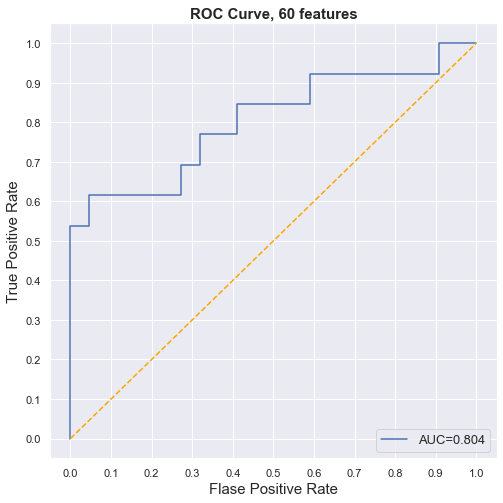

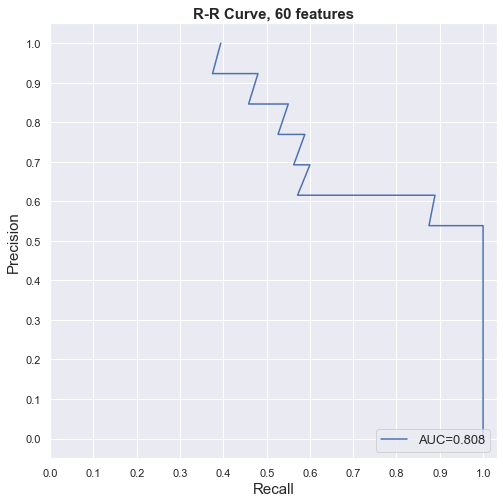

In [476]:
print(pipe_man)
test_score = pipe_man.score(X_test, y_test)
y_pred = pipe_man.predict(X_test)
y_score = [score[1] for score in pipe_man.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {len(feats_id)} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {len(feats_id)} features")

### Try heavy grid to optimize performance

In [478]:
grid_heavy = [
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [10, 100, 300, 500, 700, 1000],
        "clf__criterion": ["gini", "entropy"],
        "clf__max_depth": [3, 5, 7],
        "clf__min_samples_leaf": [10, 50, 100, 500, 1000],
        "clf__max_features": [0.1, 0.2, 0.4, 0.8, 1.0, "sqrt", "log2"],
        "sclr__scaler": [StandardScaler()],
    },
    {
        "clf": [XGBClassifier()],
        "clf__min_child_weight": [1, 5],
        "clf__gamma": [0, 1, 5],
        "clf__subsample": [0.6, 0.8, 1.0],
        "clf__colsample_bytree": [0.4, 0.7, 1.0],
        "clf__learning_rate": [0.001, 0.01, 0.1, 0.3, 0.5],
        "clf__max_depth": [4, 5, 7],
        "clf__n_estimators": [100, 300, 500, 700, 1000],
        "clf__scale_pos_weight": [10, 100, 1000],
        "sclr__scaler": [StandardScaler()],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["rbf"],
        "clf__C": [1, 10, 100, 1000],
        "clf__gamma": [1e-3, 1e-4],
        "sclr__scaler": [StandardScaler()],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["linear"],
        "clf__C": [1, 10, 100, 1000],
        "sclr__scaler": [StandardScaler()],
    },
    {
        "clf": [MLPClassifier()],
        "clf__solver": ["lbfgs"],
        "clf__max_iter": [1000, 1200, 1400, 1600, 1800, 2000],
        "clf__alpha": 10.0 ** -np.arange(1, 10),
        "clf__hidden_layer_sizes": np.arange(10, 15),
        "sclr__scaler": [StandardScaler()],
    },
]

In [479]:
pipe_man_optimized = _train(X_train, y_train, grid=grid_heavy, verbose=10, n_jobs=-1, scoring="accuracy")

Fitting 10 folds for each of 13692 candidates, totalling 136920 fits
Cross-validation scores                                                                            0      \
mean_fit_time                                                           0.029763   
std_fit_time                                                            0.004592   
mean_score_time                                                         0.005804   
std_score_time                                                          0.000957   
param_clf                                               RandomForestClassifier()   
param_clf__criterion                                                        gini   
param_clf__max_depth                                                           3   
param_clf__max_features                                                 0.100000   
param_clf__min_samples_leaf                                                   10   
param_clf__n_estimators                                            

Pipeline(steps=[('sclr', DummyScaler(scaler=StandardScaler())),
                ('clf',
                 MLPClassifier(alpha=1e-07, hidden_layer_sizes=10,
                               max_iter=1800, solver='lbfgs'))])
stats
tp: 9.0
fp: 9.0
tn: 13.0
fn: 4.0
score
roc_auc: 0.7395104895104895
accuracy: 0.6285714285714286
precision: 0.5
recall: 0.6923076923076923
specificity: 0.5909090909090909
mcc: 0.2738049460812574


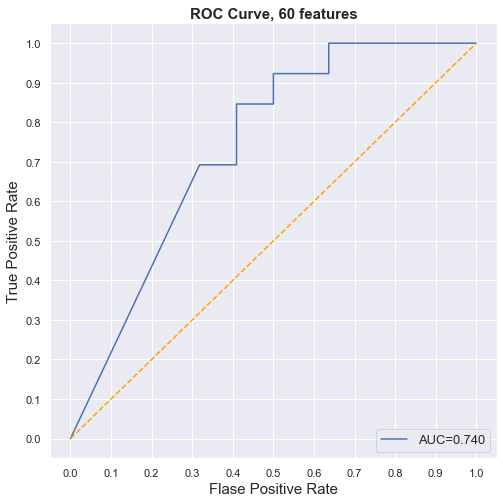

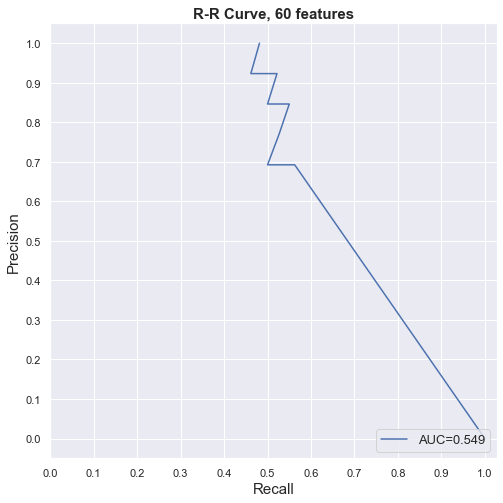

In [480]:
print(pipe_man_optimized)
test_score = pipe_man_optimized.score(X_test, y_test)
y_pred = pipe_man_optimized.predict(X_test)
y_score = [score[1] for score in pipe_man_optimized.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {len(feats_id)} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {len(feats_id)} features")

## Only remove low variance and similar features, test on manual data

In [496]:
df_man

,name,std_smiles,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,...,pychem_ATSe8,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8,label
0,paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,1.0,...,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748,1
1,vincristine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,5.0,...,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799,1
2,LTC4,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,0.0,...,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888,1
3,E217bG,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,1.0,...,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258,1
4,gemcitabine,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,1.0,...,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,CCTA-45,O=C(Nc1cccc(-c2cc(F)cc(F)c2)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.683,2.987,3.254,3.163,3.045,3.063,2.856,2.604,2.351,0
112,CCTA-46,O=C(Nc1cccc(-c2cc(F)c(F)c(F)c2)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,2.877,3.003,3.278,3.198,3.060,3.078,2.892,2.650,2.399,0
113,CCTA-47,O=C(Nc1cccc(-c2cc(F)ccc2F)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.807,2.987,3.254,3.177,3.055,3.067,2.849,2.590,2.365,0
114,CCTA-48,O=C(Nc1cccc(-c2ccc(F)c(F)c2F)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,2.981,3.003,3.278,3.211,3.075,3.078,2.885,2.636,2.412,0


In [497]:
name_train, name_test, X_train, y_train, X_test, y_test = split_data(df_man.rename(columns={"std_smiles":"smiles"}), ratio=0.7, featurized=True)
len(X_train), len(y_train), len(X_test), len(y_test)

Spliting training and test data ... Done!
train_1: 36; train_0: 45; test_1: 17; test_0: 18


(81, 81, 35, 35)

In [498]:
transformer_tr = StandardScaler().fit(X_train)
transformer_te = StandardScaler().fit(X_test)

X_train = transformer_tr.transform(X_train)
X_test = transformer_te.transform(X_test)

X_train, X_test

(array([[ 1.18657104,  0.08170903, -0.01529813, ...,  0.08104073,
          0.11299171,  0.10022146],
        [-0.97606165, -0.14138416, -0.2085453 , ...,  0.32623051,
          0.32129793,  0.32825343],
        [ 0.60050249,  0.82535299,  0.8324471 , ...,  0.88228589,
          0.91689193,  0.8569153 ],
        ...,
        [ 0.87471805, -1.03375692, -1.12995751, ..., -1.44701697,
         -1.68794703, -2.02838717],
        [-0.96521459, -0.73629933, -0.62171593, ..., -0.42794697,
         -0.47956871, -0.49638463],
        [ 0.46729721,  0.7509886 ,  0.61497518, ...,  0.39409554,
          0.43960777,  0.56559282]]),
 array([[-1.21376717, -0.75831605, -0.6158447 , ..., -0.49869297,
         -0.57124373, -0.54071468],
        [ 0.81825572, -0.96459373, -1.02025648, ..., -1.35096628,
         -1.76640707, -2.14921868],
        [ 0.06041111, -0.8958345 , -0.87420266, ..., -1.05820064,
         -0.78081745, -0.63322766],
        ...,
        [-1.07175349, -0.41451991, -0.42136667, ..., -

In [499]:
support_similar, X_train = _remove_similar_features(X_train)
X_train.shape

Calculating correlation matrix ... Done!
Creating correlation graph ... Done!


(81, 415)

In [506]:
support_similar

array([  0,   6,   7,   9,  15,  18,  19,  23,  25,  26,  29,  33,  34,
        35,  36,  37,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  56,  57,  58,  59,  61,  64,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  82,  83,  84,  85,  87,
        90,  91,  92,  93,  94,  95,  97,  98, 100, 102, 103, 104, 105,
       133, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 162, 163, 164, 165, 173, 174, 175, 184, 189, 190, 192, 193,
       197, 212, 213, 217, 228, 245, 246, 250, 254, 257, 263, 271, 276,
       277, 278, 279, 295, 298, 302, 303, 304, 311, 325, 326, 327, 335,
       343, 351, 359, 374, 384, 385, 386, 387, 388, 390, 391, 392, 397,
       398, 399, 400, 401, 402, 405, 407, 409, 410, 412, 413, 415, 416,
       418, 419, 423, 424, 426, 429, 430, 431, 432, 434, 435, 436, 437,
       438, 439, 440, 441, 443, 444, 451, 452, 453, 454, 455, 456, 457,
       458, 459, 460, 461, 462, 463, 464, 465, 467, 468, 469, 47

In [500]:
X_train = X_train.values

In [ ]:
support_lowvar, X_train = _remove_low_variance_features(X_train)
X_train.shape

In [507]:
support_lowvar

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [501]:
X_test = X_test[:, support_similar]
X_test.shape

(35, 415)

In [502]:
X_test

array([[-1.21376717, -0.44651646, -0.59963468, ..., -0.68991711,
        -0.39056846, -0.57124373],
       [ 0.81825572, -0.44651646,  0.50495552, ..., -0.45106065,
        -0.39056846, -1.76640707],
       [ 0.06041111, -0.44651646, -0.59963468, ..., -0.60923741,
        -1.61542587, -0.78081745],
       ...,
       [-1.07175349, -0.44651646, -0.59963468, ..., -0.68991711,
         0.52904057, -0.16791318],
       [-0.72658136, -0.44651646, -0.59963468, ..., -0.27888031,
        -0.39056846, -0.38045256],
       [ 0.86489231, -0.44651646, -0.59963468, ..., -0.45217457,
        -0.39056846,  0.71190102]])

In [503]:
grid_light_balance = [
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [100, 1000],
        # "clf__class_weight": [{0: 0.1, 1: 0.9}, {0: 0.01, 1: 0.99}],
        "sclr": [StandardScaler()],
    },
    {
        "clf": [XGBClassifier()],
        "clf__n_estimators": [100, 1000],
        # "clf__scale_pos_weight": [1, 10, 100, 1000],
    },
    {
        "clf": [SVC(probability=True)],
        "clf__kernel": ["rbf", "linear"],
        # "clf__class_weight": [{0: 0.1, 1: 0.9}, {0: 0.01, 1: 0.99}],
        "sclr": [StandardScaler()],
    },
    {
        "clf": [MLPClassifier()],
        "clf__solver": ["lbfgs"],
        "clf__max_iter": [1000, 2000],
        "clf__alpha": [0.1, 1],
        "clf__hidden_layer_sizes": [10, 15],
        "sclr__scaler": [StandardScaler()],
    },
]

In [504]:
pipe_man = _train(X_train, y_train, grid=grid_light_balance, verbose=10, n_jobs=-1, scoring="accuracy")

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Cross-validation scores                                                                               0   \
mean_fit_time                                                           0.217569   
std_fit_time                                                            0.003486   
mean_score_time                                                         0.016333   
std_score_time                                                          0.000897   
param_clf                                               RandomForestClassifier()   
param_clf__n_estimators                                                      100   
param_sclr                                                      StandardScaler()   
param_clf__kernel                                                            NaN   
param_clf__alpha                                                             NaN   
param_clf__hidden_layer_sizes                                            

Pipeline(steps=[('sclr', StandardScaler()), ('clf', RandomForestClassifier())])
stats
tp: 13.0
fp: 6.0
tn: 12.0
fn: 4.0
score
roc_auc: 0.7810457516339869
accuracy: 0.7142857142857143
precision: 0.6842105263157895
recall: 0.7647058823529411
specificity: 0.6666666666666666
mcc: 0.43278921145054855


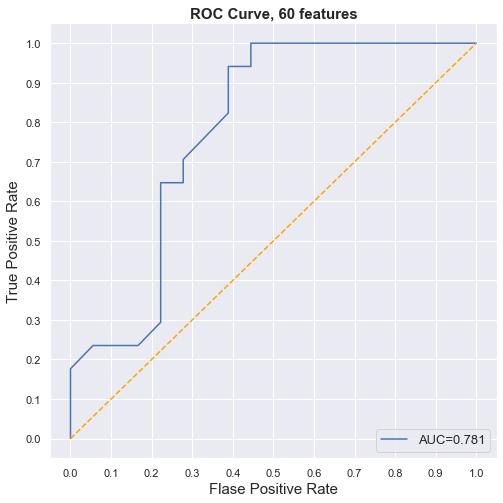

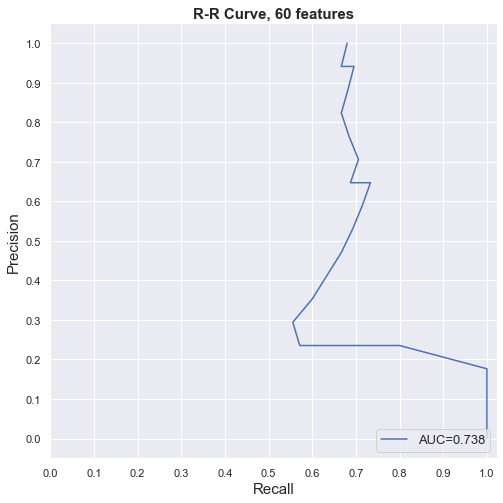

In [505]:
print(pipe_man)
test_score = pipe_man.score(X_test, y_test)
y_pred = pipe_man.predict(X_test)
y_score = [score[1] for score in pipe_man.predict_proba(X_test)]
test_scores = get_scoring(y_test, y_score, y_pred)

for item, d in test_scores.items():
    print(item)
    for title, val in d.items():
        print(f"{title}: {val}")

plot_roc_auc(y_test, y_score, title=f"ROC Curve, {len(feats_id)} features")
plot_precision_recall(y_test, y_score, title=f"R-R Curve, {len(feats_id)} features")